In [7]:

#import csv  Pythonの標準ライブラリ
%matplotlib inline
import pandas as pd
import datetime
from datetime import datetime, time, timedelta
#import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker  
from matplotlib.lines import Line2D
import datetime as dt

from sklearn.linear_model import LinearRegression
import tkinter as tk
from matplotlib import pyplot as plt
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg, NavigationToolbar2Tk)
import matplotlib.colors


from mpl_toolkits.mplot3d import Axes3D
#import japanize_matplotlib



In [8]:
import pandas as pd

def process_data(date_list, value_list):
    """
    同じ日付のデータを平均化し、日付と値のリストを返す関数

    Args:
        date_list (list): 日付の文字列を含むリスト
        value_list (list): 数値を含むリスト

    Returns:
        tuple: (新しい日付のリスト, 新しい値のリスト)
    """
    
    # 2つのリストをデータフレームに変換
    df = pd.DataFrame({
        '日付': date_list,
        '値': value_list
    })
    
    # '日付'列をキーにしてデータをグループ化し、'値'列の平均値を計算
    df_grouped = df.groupby('日付')['値'].mean().reset_index()
    
    # グループ化されたデータフレームから、新しいリストを生成
    new_date_list = df_grouped['日付'].tolist()
    new_value_list = df_grouped['値'].tolist()
    
    return new_date_list, new_value_list

# ----- 関数の使い方 -----

# サンプルデータ（同じ日付が含まれている）
dates = ['2025/8/1', '2025/8/2', '2025/8/1', '2025/8/3', '2025/8/2']
values = [300, 320, 280, 350, 310]

# 関数を呼び出して処理を実行
processed_dates, processed_values = process_data(dates, values)

print("元のデータ:", dates, values)
print("---------------------------------")
print("処理後の日付リスト:", processed_dates)
print("処理後の値リスト:", processed_values)

元のデータ: ['2025/8/1', '2025/8/2', '2025/8/1', '2025/8/3', '2025/8/2'] [300, 320, 280, 350, 310]
---------------------------------
処理後の日付リスト: ['2025/8/1', '2025/8/2', '2025/8/3']
処理後の値リスト: [290.0, 315.0, 350.0]


In [9]:
import pandas as pd
import os
import openpyxl

# 抽出したいExcelファイルが格納されているフォルダのパス
#以降のコードでも同じフォルダを使用するため、ここだけで定義します
folder_path = 'C:/Users/maeya/OneDrive/Desktop/data-analyze/data1'



# 抽出したい単語のリスト（この順番で列を結合します）
target_words = ['No.','日付', '作業者','機種', '生産数', '開始時刻', '終了時刻']

# 指定されたフォルダ内の全てのファイルを取得
for filename in os.listdir(folder_path):
    # 全てのデータを格納する空のデータフレーム
    all_data = pd.DataFrame()
    if filename.endswith('.xlsx') or filename.endswith('.xls'):
        file_path = os.path.join(folder_path, filename)
        
        try:
            print(f'--- {filename} の処理を開始します ---')
            
            # pandasでExcel全体を読み込む
            df = pd.read_excel(file_path, header=None)
            
            # openpyxlで結合セルの情報を取得
            wb = openpyxl.load_workbook(file_path, data_only=True)
            ws = wb.active
            
            file_extracted_cols = []
            
            # 欠損値補正に使う「適当な値」
            # 文字列の場合は 'N/A'、数値の場合は 0 など
            fill_value = 0
             
            for word in target_words:
                
                word_location = None
                merged_range = None
                
                # openpyxlで単語と、それが含まれる結合セルを探す
                for row_idx, row in enumerate(ws.iter_rows(min_row=1, max_row=ws.max_row)):
                    for col_idx, cell in enumerate(row):
                        #文字型かつ単語と一致するセルを探す
                        if isinstance(cell.value, str) and cell.value == word: #cellが文字型かつ単語と一致
                            word_location = (row_idx, col_idx)                 #cell座標
                            
                            # 単語が結合セルに含まれているか確認
                            for m_range in list(ws.merged_cells):
                                if cell.coordinate in m_range:                 #文字型のcell座標
                                    merged_range = m_range
                                    break
                            break
                    if word_location:
                        break
                
                if word_location:
                    start_row = word_location[0] + 4  # ここでは4行目から抽出するように設定
                    start_col = word_location[1]
                    
                    # 抽出する列の範囲を動的に決定
                    if merged_range:
                        # 結合セルの幅を計算
                        span = merged_range.max_col - merged_range.min_col + 1
                    else:
                        # 結合セルでない場合は1列
                        span = 1
                    
                    end_col = start_col + span
                    
                    print(f"'{word}'が({start_row-1}, {start_col})で見つかりました。幅は{span}列です。列 {start_col+1}-{end_col} を抽出します。")
                    
                    # データを抽出
                    extracted_data = df.iloc[start_row:, start_col:end_col]
                    
                    # 抽出した各列にユニークな名前を付けてリストに追加
                    if span > 1:
                        # 結合セルだった場合
                        extracted_data.columns = [f'{word}_{i+1}' for i in range(span)]
                        file_extracted_cols.append(extracted_data)
                    else:
                        # 結合セルでなかった場合
                        col_data = pd.DataFrame({word: extracted_data.iloc[:, 0]})
                        file_extracted_cols.append(col_data)
                else:
                    # 単語が見つからない場合、新しい列を追加
                    print(f"'{word}'はファイル内に見つかりませんでした。欠損値の列を追加します。")
                    
                    # 欠損値を含むデータフレームを作成
                    empty_col_df = pd.DataFrame({word: [None] * (len(df.index))})
                    
                    # 欠損値を補正
                    empty_col_df.fillna(fill_value, inplace=True)
                    
                    file_extracted_cols.append(empty_col_df)        

            # このファイルから抽出した複数のデータフレームを横方向に結合
            if file_extracted_cols:
                combined_df_per_file = pd.concat(file_extracted_cols, axis=1)
                all_data = pd.concat([all_data, combined_df_per_file], ignore_index=True)
            
            
            # CSVファイル名を作成（拡張子を.csvに変更）
            csv_filename = os.path.splitext(filename)[0] + '.csv'
            csv_file_path = os.path.join(folder_path, csv_filename)
            
            # データフレームをCSVファイルとして保存
            # index=Falseで、データフレームのインデックス（0, 1, 2...）をCSVに書き込まないようにします
            all_data.to_csv(csv_file_path, index=False,header=False, encoding='utf-8-sig')
            
            print(f'{filename} を {csv_filename} に変換しました。')
            
        except Exception as e:
            print(f'--- {filename} の処理中にエラーが発生しました: {e} ---')
        






--- 【秘】20240723_皆川製作所_作業記録表_P.xlsx の処理を開始します ---
'No.'が(9, 1)で見つかりました。幅は1列です。列 2-2 を抽出します。
'日付'が(9, 2)で見つかりました。幅は1列です。列 3-3 を抽出します。
'作業者'が(9, 3)で見つかりました。幅は1列です。列 4-4 を抽出します。
'機種'が(9, 5)で見つかりました。幅は1列です。列 6-6 を抽出します。
'生産数'が(9, 6)で見つかりました。幅は1列です。列 7-7 を抽出します。
'開始時刻'が(9, 7)で見つかりました。幅は2列です。列 8-9 を抽出します。
'終了時刻'が(9, 9)で見つかりました。幅は2列です。列 10-11 を抽出します。
【秘】20240723_皆川製作所_作業記録表_P.xlsx を 【秘】20240723_皆川製作所_作業記録表_P.csv に変換しました。
--- 【秘】20240723_皆川製作所_作業記録表_Q.xlsx の処理を開始します ---
'No.'が(9, 1)で見つかりました。幅は1列です。列 2-2 を抽出します。
'日付'が(9, 2)で見つかりました。幅は1列です。列 3-3 を抽出します。
'作業者'が(9, 3)で見つかりました。幅は1列です。列 4-4 を抽出します。
'機種'はファイル内に見つかりませんでした。欠損値の列を追加します。
'生産数'が(9, 4)で見つかりました。幅は1列です。列 5-5 を抽出します。
'開始時刻'が(9, 5)で見つかりました。幅は2列です。列 6-7 を抽出します。
'終了時刻'が(9, 7)で見つかりました。幅は2列です。列 8-9 を抽出します。
【秘】20240723_皆川製作所_作業記録表_Q.xlsx を 【秘】20240723_皆川製作所_作業記録表_Q.csv に変換しました。


C:\Users\maeya\AppData\Local\Temp\ipykernel_19596\2609214993.py:94: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_col_df.fillna(fill_value, inplace=True)


'2'列目のデータ: ['2023-05-09', '2023-05-10', '2023-05-12', '2023-07-10', '2023-07-12', '2023-07-13', '2023-07-28', '2023-07-31', '2023-08-01', '2023-09-13', '2023-09-14', '2023-09-15', '2023-09-19', '2023-09-20', '2023-10-11', '2023-10-12', '2023-10-28', '2023-11-17', '2024-01-22', '2024-01-23', '2024-02-05', '2024-02-06', '2024-02-08', '2024-02-09', '2024-02-13', '2024-02-14', '2024-02-15', '2024-02-27', '2024-02-28', '2024-03-15', '2024-03-18', '2024-03-22', '2024-04-02', '2024-04-03', '2024-04-09', '2024-04-10', '2024-04-30', '2024-05-01', '2024-05-02', '2024-05-11', '2024-05-21', '2024-05-22', '2024-06-13', '2024-06-14', '2024-06-15', '2024-06-26', '2024-06-27', '2024-06-28']
'5'列目のデータ: [370.0, 280.0, 360.0, 344.0, 400.0, 466.0, 422.0, 650.0, 62.0, 124.0, 548.0, 566.0, 270.0, 18.0, 140.0, 440.0, 280.0, 400.0, 288.0, 112.0, 98.0, 268.0, 272.0, 368.0, 400.0, 464.0, 130.0, 160.0, 240.0, 276.0, 352.0, 168.0, 400.0, 160.0, 87.0, 400.0, 185.0, 560.0, 400.0, 800.0, 224.0, 164.0, 472.0, 328.0, 

c:\Users\maeya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\maeya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\maeya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25240 (\N{CJK UNIFIED IDEOGRAPH-6298}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\maeya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12428 (\N{HIRAGANA LETTER RE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\maeya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.

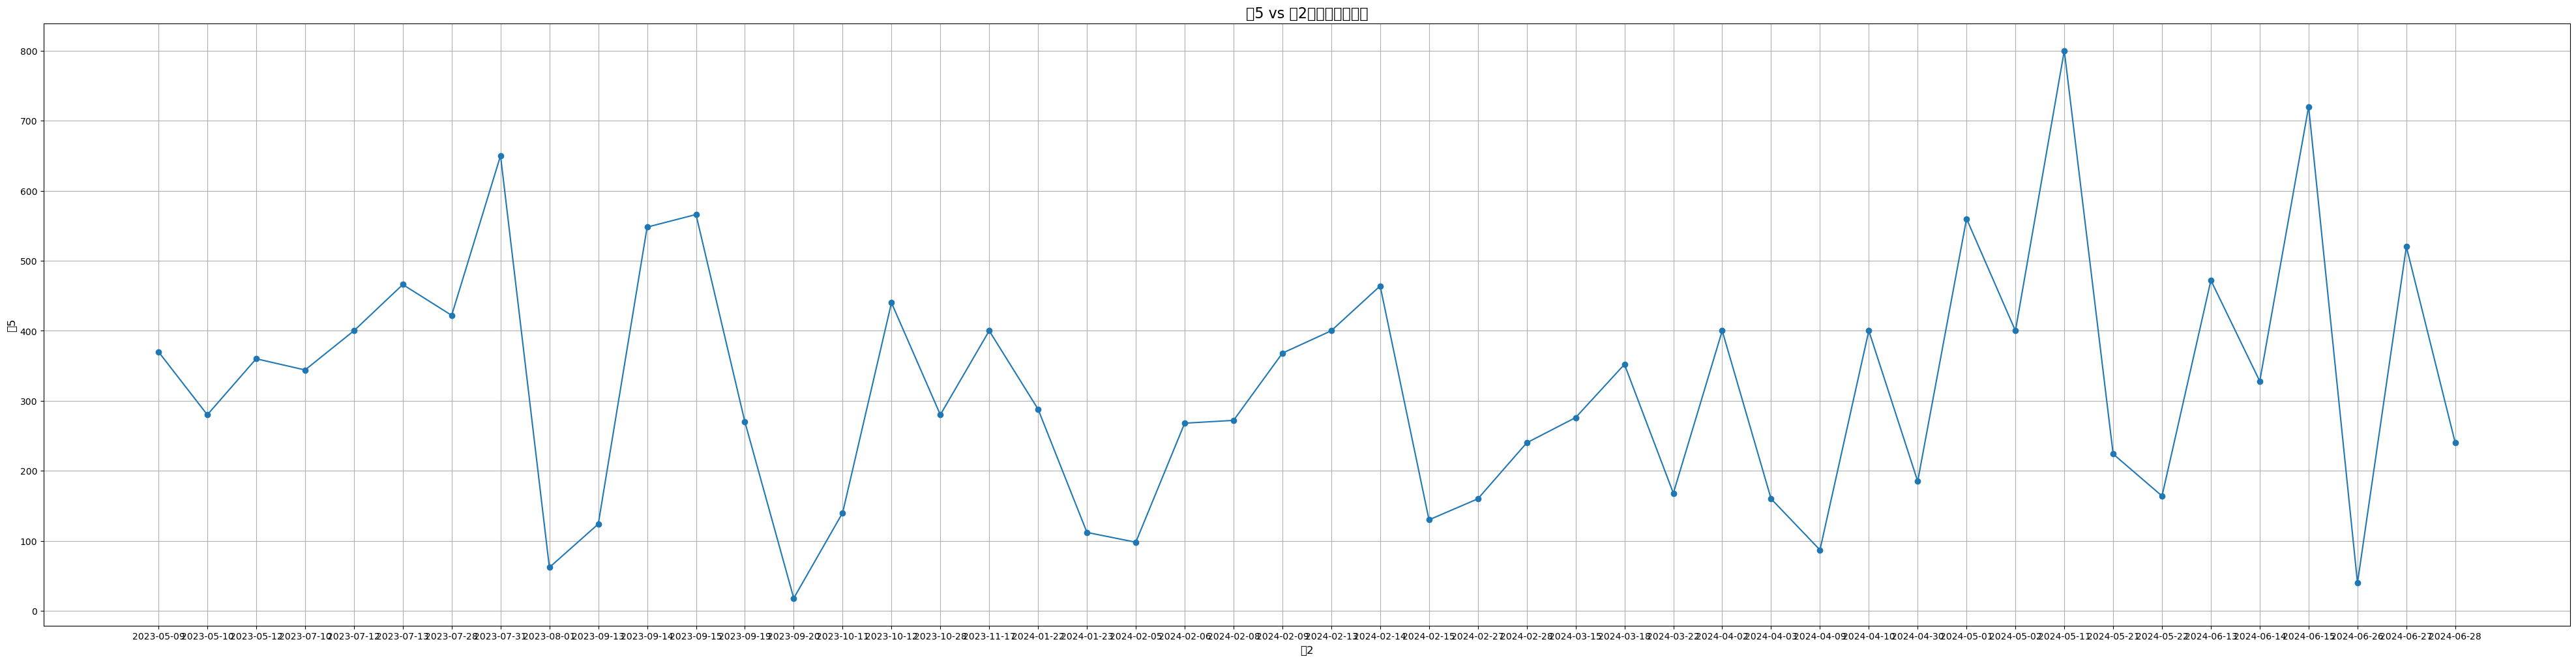

'2'列目のデータ: ['2023-04-21', '2023-04-22', '2023-04-24', '2023-05-16', '2023-05-17', '2023-05-18', '2023-05-25', '2023-05-26', '2023-05-29', '2023-05-30', '2023-05-31', '2023-06-01', '2023-06-02', '2023-06-05', '2023-06-06', '2023-06-07', '2023-06-09', '2023-06-12', '2023-06-13', '2023-06-14', '2023-06-15', '2023-06-17', '2023-06-20', '2023-06-21', '2023-06-26', '2023-06-27', '2023-06-28', '2023-06-29', '2023-06-30', '2023-07-01', '2023-07-03', '2023-07-04', '2023-07-05', '2023-07-06', '2023-07-07', '2023-07-08', '2023-07-10', '2023-07-11', '2023-07-12', '2023-07-13', '2023-07-14', '2023-07-18', '2023-07-19', '2023-07-20', '2023-07-21', '2023-07-22', '2023-07-24', '2023-07-25', '2023-07-26', '2023-07-27', '2023-07-28', '2023-07-31', '2023-08-01', '2023-08-02', '2023-08-03', '2023-08-04', '2023-08-07', '2023-08-08', '2023-08-09', '2023-08-10', '2023-08-17', '2023-08-18', '2023-08-21', '2023-08-22', '2023-08-23', '2023-08-24', '2023-08-25', '2023-08-28', '2023-08-29', '2023-08-30', '2023-08

c:\Users\maeya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\maeya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\maeya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25240 (\N{CJK UNIFIED IDEOGRAPH-6298}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\maeya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12428 (\N{HIRAGANA LETTER RE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\maeya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.

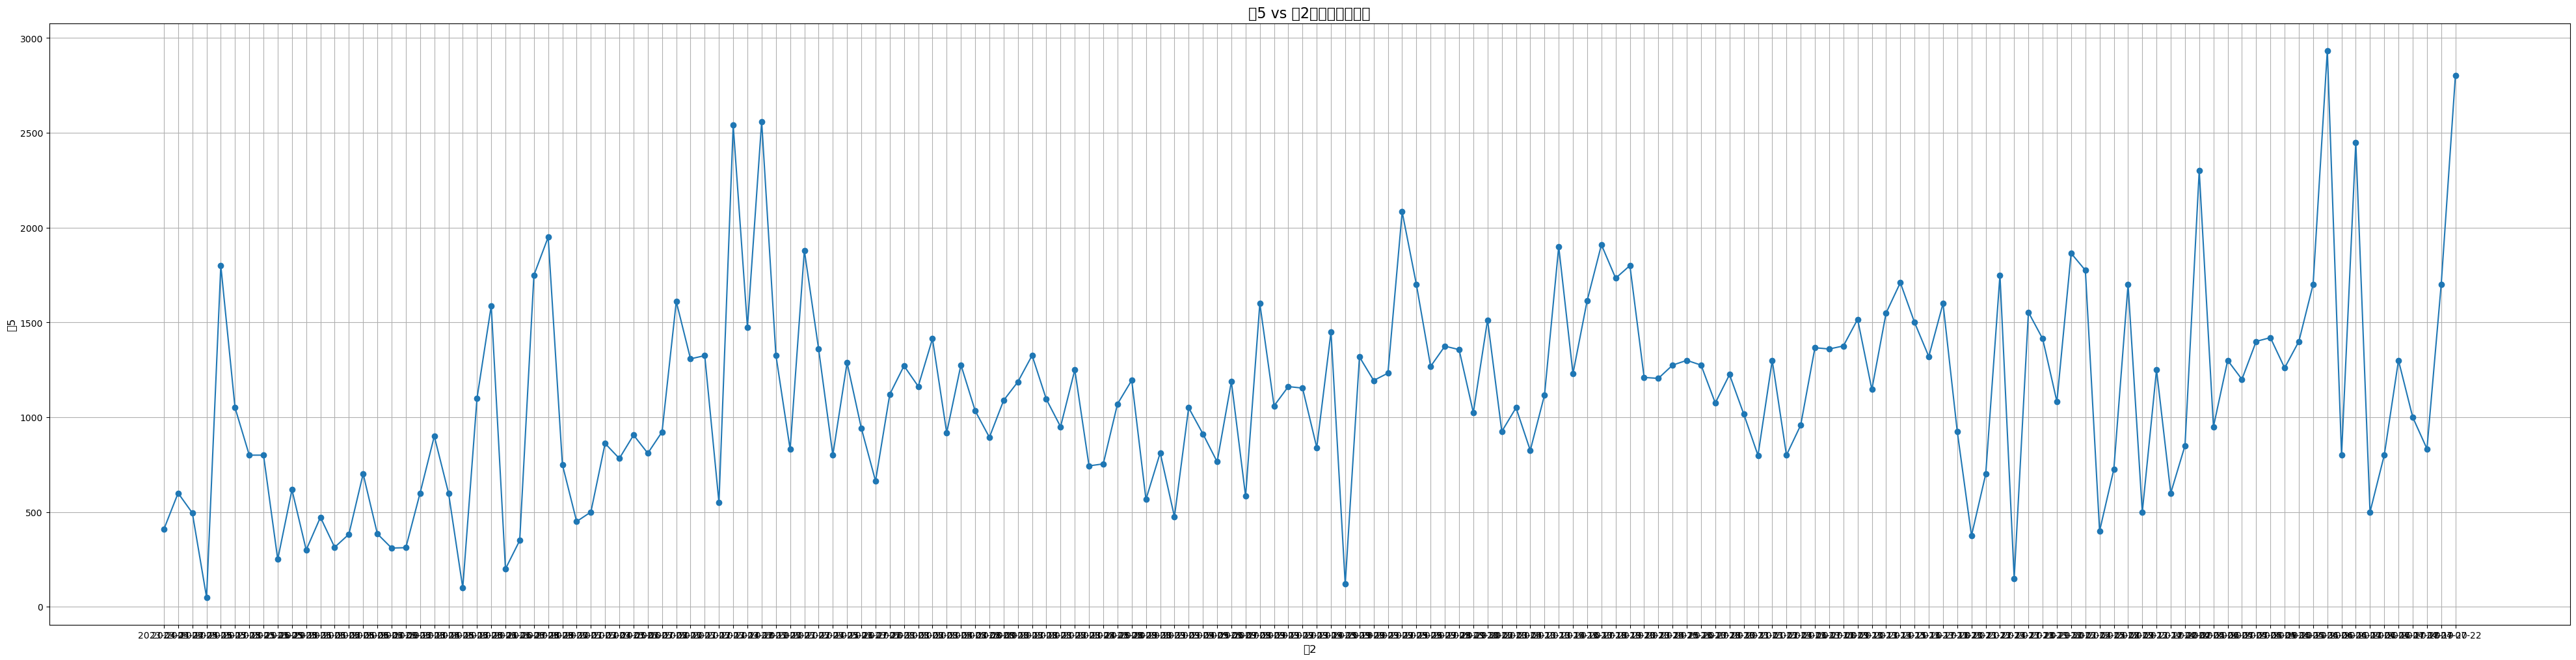

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import math


# グラフに使う列番号を指定（0から始まる）
x_column_index = 1  # 2列目のデータ
y_column_index = 4  # 5列目のデータ

for filename in os.listdir(folder_path):
    
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)

        try:
            # CSVファイルをデータフレームとして読み込む
            # header=Noneでヘッダーがない場合も対応
            # 必要に応じて、names=['列A', '列B']のように列名を付ける
            df = pd.read_csv(file_path, header=None)
            df.dtypes
            # 指定した列番号のデータを抽出
            x_data = df.iloc[:, x_column_index]
            y_data = df.iloc[:, y_column_index]
            
            # データをリストに変換（任意）
            x_list = x_data.tolist()
            y_list = y_data.tolist()

            # 日付データの0:00:00の削除、欠損値の処理
            converted_list = [item.split(' ')[0] for item in x_list if isinstance(item, str)]
            x_list= converted_list

            def is_number_and_not_nan(item):
                return isinstance(item, (int, float)) and not math.isnan(item)
            # 欠損値を削除し、int型に変換
            converted_list = [int(item) for item in y_list if is_number_and_not_nan(item)]
            y_list = converted_list
            

            new_date_list, new_value_list = process_data(x_list, y_list)
            x_list = new_date_list
            y_list = new_value_list
            

            print(f"'{x_column_index + 1}'列目のデータ:", x_list)
            print(f"'{y_column_index + 1}'列目のデータ:", y_list)
            
            # グラフの描画
            plt.figure(figsize=(50, 12))
            plt.plot(x_list, y_list, marker='o', linestyle='-')
            
            # グラフのタイトルと軸ラベルを設定
            plt.title(f'列{y_column_index + 1} vs 列{x_column_index + 1}の折れ線グラフ', fontsize=16)
            plt.xlabel(f'列{x_column_index + 1}', fontsize=12)
            plt.ylabel(f'列{y_column_index + 1}', fontsize=12)
            
            # グリッドを表示
            plt.grid(True)
            
            # グラフを表示
            plt.show()

        except FileNotFoundError:
            print(f"エラー: 指定されたファイル '{file_path}' が見つかりません。")

        except IndexError:
            print("エラー: 指定された列インデックスがファイルの列数を超えています。")

        except Exception as e:
            print(f"グラフ作成中にエラーが発生しました: {e}")
            

In [11]:
#開始時刻と終了時刻を引数として、休憩時間を引いた労働時間を求めるクラス。

class Worktime:

    def __init__(self, start_hour_row, start_minute_row, end_hour_row, end_minute_row):
         
        self.start_hours_row = start_hour_row
        self.start_minutes_row = start_minute_row
        self.end_hours_row = end_hour_row
        self.end_minutes_row = end_minute_row
        self.base_date = pd.Timestamp.today().date()

        self.start_time_series = [datetime.combine(self.base_date, time(hour=int(h), minute=int(m))) for h, m in zip(start_hour_row, start_minute_row)]
        self.end_time_series = [datetime.combine(self.base_date, time(hour=int(h), minute=int(m))) for h, m in zip(end_hour_row, end_minute_row)]
        self.work_time_series = [t2 - t1 for t1, t2 in zip(self.start_time_series, self.end_time_series)]

    def calculate_work_time(self):
        #休憩時刻を定義して、休憩時間を引いた労働時間を求める。

        breaktime_start_hour=   [10, 12, 15]  # 休憩時間の開始時刻（10:00, 12:00, 15:00）
        breaktime_start_minute= [0, 0, 0]                                           
        breaktime_end_hour=     [10, 12, 15]    # 休憩時間の終了時刻（10:10, 12:40, 15:10）
        breaktime_end_minute=   [10, 40, 10]    


        diff=[]
        breakinterval1=[]
        breakho = []
        breakmi = []
        breakse = []

        for bsh, bsm, beh, bem in zip(breaktime_start_hour, breaktime_start_minute, breaktime_end_hour, breaktime_end_minute):    
            breaktime1 = datetime.combine(self.base_date, time(hour=int(bsh), minute=int(bsm)))
            breakend1  = datetime.combine(self.base_date, time(hour=int(beh), minute=int(bem)))

            #休憩時間の差分を計算
            
            difference= breakend1 - breaktime1
            diff.append(difference)
            
        for k,i in enumerate(diff):
            total_seconds = int(i.total_seconds())         # hours, minutes, secondsに分割
            breakho.append( total_seconds // 3600)
            breakmi.append( (total_seconds % 3600) // 60)
            breakse.append(total_seconds % 60)
    
            breakinterval=timedelta(hours=breakho[k],minutes=breakmi[k])  
            breakinterval1.append(breakinterval)

        newworktime = []
    
        for s,e,w in zip(self.start_time_series, self.end_time_series, self.work_time_series):
            for b,bsh, bsm, beh, bem in zip(breakinterval1,breaktime_start_hour, breaktime_start_minute, breaktime_end_hour, breaktime_end_minute):    
                breaktime1 = datetime.combine(self.base_date, time(hour=int(bsh), minute=int(bsm)))
                breakend1  = datetime.combine(self.base_date, time(hour=int(beh), minute=int(bem)))

                if s < breaktime1 and e > breakend1:
                    w = w - b
            
                #休憩時間中に労働開始する場合
                if s >= breaktime1 and s < breakend1 and e > breakend1:
                    deffrence=b-timedelta(minutes=s.minute)
                    w = w - deffrence
                if s <= breaktime1 and e > breaktime1 and e < breakend1:
                    deffrence=b-timedelta(minutes=e.minute)
                    w = w - deffrence   

            newworktime.append(w)

            
            #秒単位を時間に変換    
        self.Newworktime = [str(timedelta(seconds=int(w.total_seconds()))) for w in newworktime]


        print("休憩時間を引いた後の勤務時間は") 
        x=0
        for i in self.Newworktime:
            x=x+1
            print(x,"    ",  i   )
        
        print("です。")
            
        return self.Newworktime




In [ ]:
# 抽出したCSVファイルを読み込み、指定した列のデータを抽出して、クラス（Worktime）を使い、休憩時間を引いた労働時間を求める。

for filename in os.listdir(folder_path):

    
    if  filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        processed_series = []

        try:
            # CSVファイルをデータフレームとして読み込む
            # header=Noneでヘッダーがない場合も対応
            # 必要に応じて、names=['列A', '列B']のように列名を付ける
            df = pd.read_csv(file_path, header=None)
            df.dtypes
            # 指定した列番号のデータを抽出
            # ここでは、開始時刻と終了時刻（時、分）の列を指定
            startrow_h = df.iloc[:, 5]
            startrow_m = df.iloc[:, 6]
            endtrow_h = df.iloc[:, 7]
            endrow_m = df.iloc[:, 8]
            # 処理後のシリーズを格納するリスト
            series_list = [startrow_h, startrow_m, endtrow_h, endrow_m]
            

            # 各シリーズをループで処理
            for s in series_list:
                # 1. 欠損値を削除
                s_cleaned = s.dropna()
                
                # 2. int型に変換
                s_int = s_cleaned.astype(int)
                
                
                # 処理後のシリーズをリストに追加
                processed_series.append(s_int)

            # 処理結果の確認
            #for s in processed_series:
                #print(s)
                #print("データ型:", s.dtype)
                #print("-" * 20)

            # Worktimeクラスのインスタンスを作成し、勤務時間を計算
            worktime1 = Worktime(processed_series[0], processed_series[1], processed_series[2], processed_series[3])
            worktime1.calculate_work_time()   
            print(worktime1.Newworktime)


            
        except Exception as e:
            print(f"グラフ作成中にエラーが発生しました: {e}")    
    

休憩時間を引いた後の勤務時間は
1      6:40:00
2      7:25:00
3      3:45:00
4      3:45:00
5      3:30:00
6      4:00:00
7      4:10:00
8      3:55:00
9      5:20:00
10      0:30:00
11      1:20:00
12      5:20:00
13      5:20:00
14      3:30:00
15      1:40:00
16      0:15:00
17      2:30:00
18      5:20:00
19      4:20:00
20      4:00:00
21      2:30:00
22      0:55:00
23      1:30:00
24      4:30:00
25      4:30:00
26      4:30:00
27      4:30:00
28      4:30:00
29      1:30:00
30      1:40:00
31      3:15:00
32      3:25:00
33      3:15:00
34      1:50:00
35      4:25:00
36      1:50:00
37      1:25:00
38      0:55:00
39      4:25:00
40      1:50:00
41      2:20:00
42      7:45:00
43      5:25:00
44      7:55:00
45      2:35:00
46      1:50:00
47      1:10:00
48      4:25:00
49      3:25:00
50      5:55:00
51      0:50:00
52      7:55:00
53      3:55:00
です。
['6:40:00', '7:25:00', '3:45:00', '3:45:00', '3:30:00', '4:00:00', '4:10:00', '3:55:00', '5:20:00', '0:30:00', '1:20:00', '5:20:00', '5:20:00